In [1]:
import sys
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from matplotlib import pyplot

In [2]:
# !wget --no-check-certificate \
#     "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
#     -O "/tmp/cats-and-dogs.zip"

# local_zip = '/tmp/cats-and-dogs.zip'
# zip_ref   = zipfile.ZipFile(local_zip, 'r')
# zip_ref.extractall('/tmp')
# zip_ref.close()

In [3]:
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

# Expected Output:
# 12501
# 12501

250
278


In [4]:
try:
    os.mkdir('/tmp/cats-v-dogs')
    os.mkdir('/tmp/cats-v-dogs/train')
    os.mkdir('/tmp/cats-v-dogs/test')
    os.mkdir('/tmp/cats-v-dogs/train/cats')
    os.mkdir('/tmp/cats-v-dogs/train/dogs')
    os.mkdir('/tmp/cats-v-dogs/test/cats')
    os.mkdir('/tmp/cats-v-dogs/test/dogs')
except OSError:
    pass

In [5]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)

In [6]:
CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAIN_CATS_DIR = "/tmp/cats-v-dogs/train/cats/" 
TEST_CATS_DIR = "/tmp/cats-v-dogs/test/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAIN_DOGS_DIR = "/tmp/cats-v-dogs/train/dogs/"
TEST_DOGS_DIR = "/tmp/cats-v-dogs/test/dogs/"

split_size = .7
split_data(CAT_SOURCE_DIR, TRAIN_CATS_DIR, TEST_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAIN_DOGS_DIR, TEST_DOGS_DIR, split_size)

# Expected output
# 666.jpg is zero length, so ignoring
# 11702.jpg is zero length, so ignoring

In [7]:

print(len(os.listdir('/tmp/cats-v-dogs/train/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/train/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/test/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/test/dogs/')))

# Expected output:
# 11250
# 11250
# 1250
# 1250

175
194
75
84


In [8]:
#input dimension
IMG_CHANNELS = 3
IMG_ROWS = 150
IMG_COLS = 150

#constant
BATCH_SIZE = 20
EPOCHS = 5

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])


In [9]:

TRAIN_DIR = "/tmp/cats-v-dogs/train/"

# 아래의 방법을 통해 이미지를 늘릴 수 있다. 아래는 이미지데이터를 시프트하거나 회전시켜서 같은 이미지를 뻥튀기 시키는 것이다.
train_datagen = ImageDataGenerator(rescale=1.0/255.,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
#train_datagen = ImageDataGenerator(rescale=1.0/255.)
train_generator = train_datagen.flow_from_directory(TRAIN_DIR, 
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='binary',
                                                    target_size=(IMG_ROWS, IMG_COLS))

TEST_DIR = "/tmp/cats-v-dogs/test/"
validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(TEST_DIR,
                                                              batch_size=BATCH_SIZE,
                                                              class_mode='binary',
                                                              target_size=(IMG_ROWS, IMG_COLS))

# Expected Output:
# Found 22498 images belonging to 2 classes.
# Found 2500 images belonging to 2 classes.

Found 369 images belonging to 2 classes.
Found 159 images belonging to 2 classes.


In [10]:
train_generator.class_indices

{'cats': 0, 'dogs': 1}

In [11]:
history = model.fit(
        train_generator,
        steps_per_epoch= len(train_generator),        
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        epochs=EPOCHS)

Epoch 1/5
19/19 [==============================] - 3s 166ms/step - loss: 1.0682 - acc: 0.5799 - val_loss: 0.6304 - val_acc: 0.6541
Epoch 2/5
19/19 [==============================] - 3s 158ms/step - loss: 0.6793 - acc: 0.6396 - val_loss: 0.4938 - val_acc: 0.8176
Epoch 3/5
19/19 [==============================] - 3s 158ms/step - loss: 0.6093 - acc: 0.6965 - val_loss: 0.7023 - val_acc: 0.6667
Epoch 4/5
19/19 [==============================] - 3s 160ms/step - loss: 0.5316 - acc: 0.7453 - val_loss: 0.3882 - val_acc: 0.8176
Epoch 5/5
19/19 [==============================] - 3s 152ms/step - loss: 0.4989 - acc: 0.7642 - val_loss: 0.3373 - val_acc: 0.8616


In [12]:
# evaluate model
_, acc = model.evaluate(validation_generator, steps=len(validation_generator), verbose=0)
print('Test accuracy : %.3f' % (acc * 100.0))

Test accuracy : 86.164


In [13]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
  # plot loss
  # pyplot.subplot(211)
  pyplot.title('Cross Entropy Loss')
  pyplot.plot(history.history['loss'], color='blue', label='train')
  pyplot.plot(history.history['val_loss'], color='orange', label='test')
  pyplot.figure()

  # plot accuracy
  # pyplot.subplot(212)
  pyplot.title('Classification Accuracy')
  pyplot.plot(history.history['acc'], color='blue', label='train')
  pyplot.plot(history.history['val_acc'], color='orange', label='test')
  pyplot.figure()

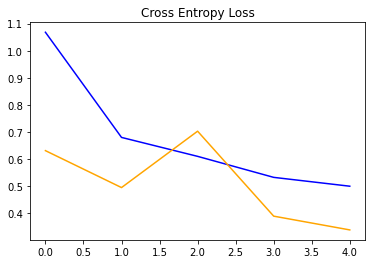

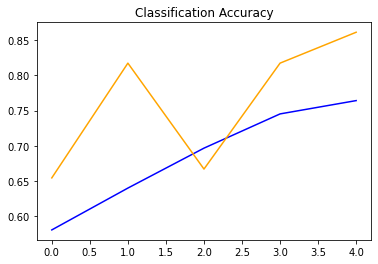

<Figure size 432x288 with 0 Axes>

In [14]:
summarize_diagnostics(history)

In [15]:
import time
t = time.time()

export_file = "/tmp/saved_models/mymodel_{}.hdf5".format(int(t))
model.save(export_file)
export_file

'/tmp/saved_models/mymodel_1603525477.hdf5'

In [16]:
reconstructed_model = tf.keras.models.load_model(export_file)

In [17]:
_, acc = reconstructed_model.evaluate(validation_generator, steps=len(validation_generator), verbose=0)
print('Test accuracy : %.3f' % (acc * 100.0))

Test accuracy : 86.164
